Яндекс готовит спецпроект, посвященный Чемпионату мира по футболу. Нужно сделать колдунщик, а чтобы он получился качественным, необходимо знать, что интересует пользователей в связи с этим событием: до него, во время и после. 

Для этого вам предлагается проанализировать логи поисковых запросов. Предложите несколько вариантов классификации этих запросов. Расчётную часть выполните на любом скриптовом языке программирования. К заданию приложите ваш скрипт и отчёт, включающий анализ и выводы (сам колдунщик делать не нужно).

Данные могут быть скачены по ссылке:

https://yadi.sk/d/C3xzGaNm3O-c8Q

# Подготовка

In [1]:
from time import time
import random
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import NMF, LatentDirichletAllocation, PCA
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Normalizer
from sklearn import metrics

from pymorphy2 import MorphAnalyzer

MORPH = MorphAnalyzer()

In [2]:
with open("./data/stopwords-ru.txt", encoding="utf-8") as f:
    stop_words = list(map(str.strip, f.readlines()))

In [3]:
class KMeansAnalizer:
    """
    Класс для определения кол-ва кластеров
    """
    def __init__(self, clusterer, data):
        self._clusterer = clusterer
        self._data = data
        self._inertia = {}
        self._labels = {}
        self._silhouette = {}
        
    def explore(self, range_inst: "range"):
        for k in range_inst:
            if k in self._inertia:
                continue
            print(f"fitting {k} clusters")
            self._clusterer.n_clusters = k
            self._clusterer.init_size = k * 3
            self._clusterer.fit(self._data)
            self._inertia.update({k: np.sqrt(self._clusterer.inertia_)})
            self._labels.update({k: self._clusterer.labels_})
            
    def plot_elbow(self):
        plt.plot(self._inertia.keys(), self._inertia.values(), marker='s');
        plt.xlabel('$k$')
        plt.ylabel('$J(C_k)$');
        
    def _calculate_silhouette(self):
        for k, labels in self._labels.items():
            if k not in self._silhouette:
                print(f"Calculating silhouette for {k} clusters")
                self._silhouette.update({k: metrics.silhouette_score(self._data, labels)})
        
    def plot_silhouette(self):
        self._calculate_silhouette()
        plt.plot(self._silhouette.keys(), self._silhouette.values(), marker='s');
        plt.xlabel('$k$')
        plt.ylabel('$Silhouette$');

In [4]:
from collections import Counter

class WordFreqsCounter:
    """
    Класс для подсчета частот слов
    """
    def __init__(self, normal_form=False):
        self.normal = normal_form
        self._freqs = Counter()
    
    def count_freqs(self, document, stop_words):
        stop_words = set(stop_words)
        for term in document:
            if self.normal:  # приведение к нормальной форме: "дверью" -> "дверь"
                term = [m.parse(word)[0].normal_form for word in term.split() if word not in stop_words]
            else:
                term = [word for word in term.split() if word not in stop_words]
            self._freqs.update(term)
            
    @property
    def freqs(self):
        return pd.Series(self._freqs).sort_values(ascending=False)

In [5]:
class LemmTfidfVectorizer(TfidfVectorizer):
    """
    Добавляет функционал MorphAnalizer
    """
    def build_analyzer(self):
        analyzer = super(TfidfVectorizer, self).build_analyzer()
        def parse_analyzer(data):
            for word in analyzer(data):
                yield MORPH.parse(word)[0].normal_form
        return parse_analyzer

# EDA

In [6]:
data = pd.read_csv("./data/football", nrows=1000000, sep="\t")
data.dropna(inplace=True)
data.datetime = pd.to_datetime(data.datetime)

In [7]:
data.describe()

,normal_query,datetime
count,999999,999999
unique,776657,73401
top,вк,2018-06-19 11:42:22
freq,6364,48
first,NaN,2018-06-14 01:56:52
last,NaN,2018-07-15 19:44:49


Работаем на примере запросов в период с 2018-06-14 по 2018-07-15 (1 месяц)

Как распределены частоты слов?

In [8]:
%%time

wfc = WordFreqsCounter()
wfc.count_freqs(data["normal_query"].values, stop_words)

# отсеиваем слова, состоящие только из цифр
digit_filter = np.core.defchararray.isdigit(wfc.freqs.index.tolist())

Wall time: 18.9 s


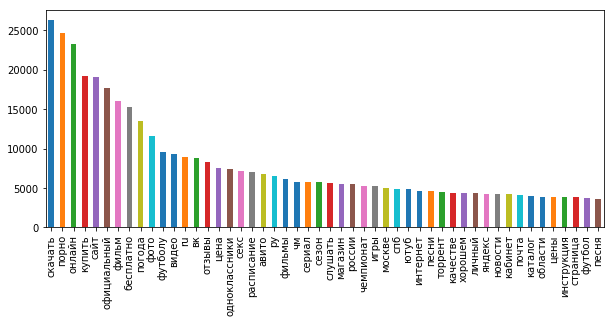

In [9]:
wfc.freqs[~digit_filter].head(50).plot(kind="bar", figsize=(10, 4));

# Кластеризация

Используем векторизатор Tf Idf так как он позволяет учитывать частоту появления слов как в отдельном запросе так и во всех запросах в целом.

Используем N-граммы 1 и 2 чтобы использовать в качестве признаков отдельные слова и словосочетания.

https://scikit-learn.org/stable/modules/feature_extraction

Используем кластеризатор MiniBatchKMeans так как он работает быстрее обычного KMeans.

https://scikit-learn.org/stable/auto_examples/cluster/plot_mini_batch_kmeans.html

In [10]:
# параметры векторизатора
v_params = {
    "max_df": 0.95,  # используем слова, которые встречаются не более чем в 95% запросов
    "min_df": 2, # используем слова, которые встречаются не менее 2 раз
    "stop_words": stop_words,
    "max_features": 2000,
    "ngram_range": (1, 2)
}

In [11]:
# параметры кластеризатора
mb_params = {
    "init": "k-means++",
    "n_init": 10,
    "max_no_improvement": 10,
    "batch_size": 45
}

In [12]:
tfidf = LemmTfidfVectorizer(v_params)

mb = MiniBatchKMeans(**mb_params)

Приводим наши запросы к векторной форме:

In [13]:
%%time

X = tfidf.fit_transform(data["normal_query"])

Wall time: 8min 48s


Оценка необходимого числа кластеров методом локтя

Критерий - сумма квадратов расстояний от точек до центроидов кластеров, к которым они относятся

In [14]:
# kma = KMeansAnalizer(mb, X)

In [15]:
# %%time

# kma.explore(range(10, 200, 20))

In [16]:
# kma.plot_elbow()

Перегиб приблизительно в районе 70 кластеров

In [17]:
%%time

mb_params["n_clusters"] = 70

mb1 = MiniBatchKMeans(**mb_params)
mb1.fit(X)

Wall time: 8min 35s


In [18]:
%%time

data['labels'] = mb1.labels_
clustered_data = data.groupby("labels")["normal_query"].apply(lambda x: np.unique(x))
print(f"Got {clustered_data.shape[0]} clusters")

Got 69 clusters
Wall time: 1.31 s


Алгоритм собрал 69 кластеров

Наиболее популярные слова в первых 10 кластерах:

In [19]:
order_centroids = mb1.cluster_centers_.argsort()[:, ::-1]

terms = tfidf.get_feature_names()
for i in range(10):
    print("Cluster %d:" % (i + 1), end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

Cluster 1: бухгалтер сочи вакансия работа 𝑎𝑥 xsd xs3868 xs4600 xsa xsacura
Cluster 2: вк скачать порно 𝑎𝑥 xsacura xs1487339290 xs2 xs3868 xs4600 xsa
Cluster 3: онлайн смотреть серия русский бесплатно сезон сериал весь качество хороший
Cluster 4: вк вход как поиск скачать порно на фото группа видео
Cluster 5: россия хорватия июль испания 2018 футбол матч египет почта саудовский
Cluster 6: чек показывать оплата налог нужно продажа после квартира ли xs2
Cluster 7: сбербанк онлайн бизнес кредит официальный сайт вход калькулятор ипотека как
Cluster 8: авить авто область на пробег купить объявление недвижимость квартира вакансия
Cluster 9: ведьмак персонаж охота дикий секрет через торрент игра русский бесплатно
Cluster 10: порно русский смотреть онлайн зрелый бесплатно 365 домашний фото комикс


Примеры запросов из кластеров

In [20]:
for ind, clust in clustered_data.iloc[:10].iteritems():
    print("Cluster %d:\n" % (ind + 1), "\n".join(clust[:5]), sep="\n", end="\n\n")

Cluster 1:

авито работа сочи свежие вакансии
бухгалтер
бухгалтер в школу вакансии в ярославле
бухгалтер вакансия бузулук
бухгалтер на удаленную работу

Cluster 2:

вк ru
вк порно
вк скачать
для вк g s j
порно в вк

Cluster 3:

007 квант милосердия смотреть онлайн hd 1080
1 1 смотреть онлайн фильм бесплатно в хорошем качестве
1 2 смотреть онлайн
1 c охраны труда онлайн бесплатно
1 канал садовое кольцо 10 серия сериал 2018 смотреть сериал онлайн

Cluster 4:

152 школа спб в вк
18 вк
220 вк
220 вк ком
220 вк скрытые друзья

Cluster 5:

001 россия поезд красноярск челябинск
04 регион это какой город россии
07 какой регион в россии
1 4 россия
1 4 финал футбола россия

Cluster 6:

налог на продажу квартиры
нужно ли показывать чек после оплаты налога с продажи
нужно ли показывать чек после оплаты налога с продажи квартиры

Cluster 7:

100 рублей к чемпионату купить в сбербанке
900 сбербанк круглосуточно
c сбербанк онлайн
cпасибо от сбербанка
domclick ru от сбербанка уменьшение процентной ста